In [122]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf

matplotlib.style.use('ggplot')

## Load and clean up data
Extract the date from the testID, and timestamp from date, save log2 values of the base and peak performance values.

In [3]:
vortex_cpu_data = pandas.read_csv(r'./benchmarks_255_vortex.csv')

In [55]:
vortex_cpu_data['date'] = [datetime.strptime(x.split('-')[1], '%Y%m%d') 
                           for x in vortex_cpu_data.testID]
vortex_cpu_data['timestamp'] = [x.timestamp() for x in vortex_cpu_data['date']]
vortex_cpu_data['log_base'] = np.log2(vortex_cpu_data.base)
vortex_cpu_data['log_peak'] = np.log2(vortex_cpu_data.peak)
vortex_cpu_data['const'] = 1

## Fit a linear model to log base performance and plot

In [120]:
X = vortex_cpu_data['timestamp']
X = sm.add_constant(X)
y_base = vortex_cpu_data['log_base']

base_model = sm.OLS(y_base, X)
base_results = base_model.fit()
vortex_cpu_data['base_regression_y'] = base_results.predict(X)
base_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_base   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     5250.
Date:                Fri, 08 Sep 2017   Prob (F-statistic):               0.00
Time:                        15:38:36   Log-Likelihood:                -887.36
No. Observations:                1374   AIC:                             1779.
Df Residuals:                    1372   BIC:                             1789.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -4.5122      0.211    -21.335      0.000        -4.927    -4.097
timestamp   1.403e-08   1.94e-10     72.460      0.000      1.36e-08  1.44e-08
==============================================================================
Omnibus:                      537.959   Durbin-Watson:                   1.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4481.835
Skew:                          -1.593   Prob(JB):                         0.00
Kurtosis:                      11.254   Cond. No.                     1.85e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

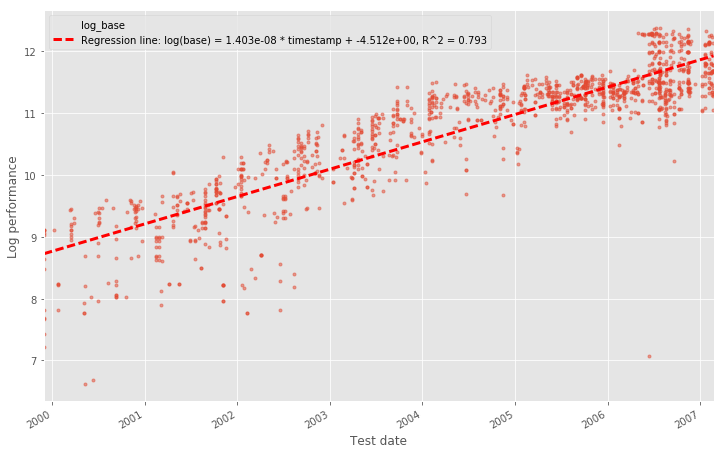

In [121]:
axes = vortex_cpu_data.plot(x='date', y='log_base', style='.', alpha=0.5, figsize=(12, 8))
vortex_cpu_data.plot(x='date', y='base_regression_y', style='--', 
                     color='red', lw=3, ax=axes,
                    label='Regression line: log(base) = {m:.3e} * timestamp + {c:.3e}, R^2 = {r2:.3f}'
            .format(m=base_results.params['timestamp'], c=base_results.params['const'], 
                    r2=base_results.rsquared))
axes.set_xlabel('Test date')
axes.set_ylabel('Log performance')
plt.show()

## Fit a linear model to log peak performance and plot

In [109]:
peak_model = smf.ols('log_peak ~ timestamp + const', data=vortex_cpu_data, missing='drop')
peak_results = peak_model.fit()

# hacking around to handle NaN values
vortex_cpu_data['peak_regression_y'] = float('NaN')
vortex_cpu_data.loc[vortex_cpu_data.log_peak.notnull(), 'peak_regression_y'] = peak_results.predict()
peak_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_peak   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     5411.
Date:                Thu, 07 Sep 2017   Prob (F-statistic):               0.00
Time:                        14:52:45   Log-Likelihood:                -642.82
No. Observations:                1241   AIC:                             1290.
Df Residuals:                    1239   BIC:                             1300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.9124      0.100    -19.188      0.000        -2.108    -1.717
timestamp   1.346e-08   1.83e-10     73.556      0.000      1.31e-08  1.38e-08
const         -1.9124      0.100    -19.188      0.000        -2.108    -1.717
==============================================================================
Omnibus:                      242.208   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              542.194
Skew:                          -1.083   Prob(JB):                    1.84e-118
Kurtosis:                       5.407   Cond. No.                     6.70e+24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.28e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

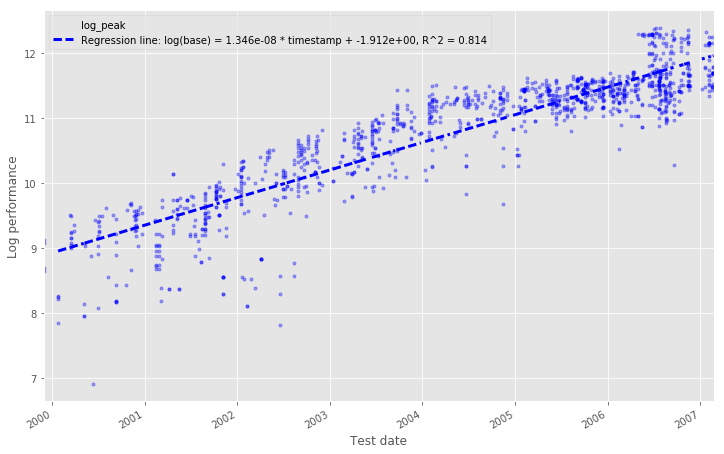

In [112]:
axes = vortex_cpu_data.plot(x='date', y='log_peak', style='.', 
                            color='blue', alpha=0.33, figsize=(12, 8))
vortex_cpu_data.plot(x='date', y='peak_regression_y', style='--', 
                     color='blue', lw=3, ax=axes,
                    label='Regression line: log(base) = {m:.3e} * timestamp + {c:.3e}, R^2 = {r2:.3f}'
            .format(m=peak_results.params['timestamp'], c=peak_results.params['const'], 
                    r2=peak_results.rsquared))
axes.set_xlabel('Test date')
axes.set_ylabel('Log performance')
plt.show()

# Moore's Law

It appears that Moore's law roughly holds as noisy as the data is. Both models achieve $R^2$ values of around 0.8 (0.793 and 0.814), meaning that around 80% of the variance in $\log_2(performance)$ is explained by the variance in dates. Since the plots (and regression) are in log 2, every increase of 1 in the Y axis corresponds to doubling the performance. From the data it appears to be slightly longer than two years (perhaps ~2.5), but still appears to be growing strong. 